# Introduction to Reinforcement Learning
OCNC 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## Classes for minimum environment and agent

In [2]:
class Environment:
    """Class for a reinforcement learning environment"""
    
    def __init__(self, nstate=3, naction=2):
        """Create a new environment"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        
    def start(self):
        """start an episode"""
        # randomly pick a state
        self.state = np.random.randint(self.Ns)
        return(self.state)
    
    def step(self, action):
        """step by an action"""
        # random reward
        self.reward = np.random.random()  # between 0 and 1
        # shift up/down and rotate in [0,Ns)
        self.state = (self.state+(-1 if action==0 else 1))%self.Ns
        return(self.reward, self.state)

In [3]:
class Agent:
    """Class for a reinforcement learning agent"""
    
    def __init__(self, nstate, naction):
        """Create a new agent"""
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        
    def start(self, state):
        """first action, without reward feedback"""
        # randomly pick an action
        self.action = np.random.randint(self.Na)
        return(self.action)
    
    def step(self, reward, state):
        """learn by reward and take an action"""
        # do nothing for reward
        # randomly pick an action
        self.action = np.random.randint(self.Na)
        return(self.action)

In [4]:
class RL:
    """Reinforcement learning by interacton of Environment and Agent"""

    def __init__(self, environment, agent, nstate, naction):
        """Create the environment and the agent"""
        self.env = environment(nstate, naction)
        self.agent = agent(nstate, naction)
    
    def episode(self, tmax=50):
        """One episode"""
        # First contact
        state = self.env.start()
        action = self.agent.start(state)
        # Table of t, r, s, a
        Trsa = np.zeros((tmax+1,4))
        Trsa[0,:] = [0, 0, state, action]
        # Repeat interactoin
        for t in range(1, tmax+1):
            reward, state = self.env.step(action)
            action = self.agent.step(reward, state)
            Trsa[t,:] = [t, reward, state, action]
        return(Trsa)
    
    def run(self, nrun=10, tmax=50):
        """Multiple runs of episodes"""
        Return = np.zeros(nrun)
        for n in range(nrun):
            r = self.episode(tmax)[:,1]  # reward sequence
            Return[n] = sum(r)
        return(Return)

## Q learning of Pain-Gain task

In [5]:
class PainGain(Environment):
    """Pain-Gain environment """
    
    def __init__(self, nstate=4, naction=2, gain=6):
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        # setup the reward function as an array
        self.R = np.ones((self.Ns, self.Na))
        self.R[0,1] = -1   # small pains for action 1
        self.R[0,0] = -gain  # large pain
        self.R[-1,1] = gain  # large gain
    
    def step(self, action):
        """step by an action"""
        self.reward = self.R[self.state, action]  # reward
        self.state = (self.state + 2*action-1)%self.Ns  # move left or right
        return(self.reward, self.state)

In [6]:
class QL(Agent):
    """Class for a Q-learning agent"""
    
    def __init__(self, nstate, naction):
        self.Ns = nstate   # number of states
        self.Na = naction  # number of actions
        # allocate Q table
        self.Q = np.zeros((nstate, naction))
        # default parameters
        self.alpha = 0.1  # learning rate
        self.beta = 2.0   # inverse temperature
        self.gamma = 0.9  # discount factor
    
    def boltzmann(self, q):
        """Boltzmann selection"""
        p = np.exp( self.beta*q)   # unnormalized probability
        p = p/sum(p)    # probability
        # take the index of a segment in [0,1]
        return(np.searchsorted( np.cumsum(p), np.random.random()))

    def start(self, state):
        """first action, without reward feedback"""
        # Boltzmann action selection
        self.action = self.boltzmann( self.Q[state,:])
        # remember the state
        self.state = state
        return(self.action)
    
    def step(self, reward, state):
        """learn by reward and take an action"""
        # TD error: self.state/action retains the previous ones
        delta = reward + self.gamma*max(self.Q[state,:]) - self.Q[self.state,self.action]
        # Update the value for previous state and action
        self.Q[self.state,self.action] += self.alpha*delta
        # Boltzmann action selection
        self.action = self.boltzmann( self.Q[state,:])
        # remember the state
        self.state = state
        return(self.action)

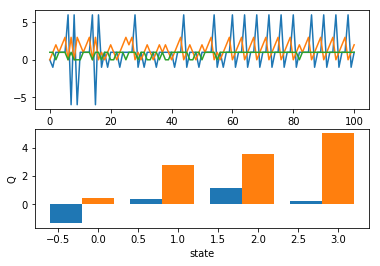

In [7]:
# Pain-Gain environment and Q-learning agent
pgq = RL(PainGain, QL, 4, 2)
trsa = pgq.episode(100)
plt.subplot(2,1,1)
plt.plot(trsa[:,1:]);
plt.subplot(2,1,2)
plt.bar(np.arange(0,pgq.agent.Ns)-0.4, pgq.agent.Q[:,0], 0.4)  # action 0
plt.bar(np.arange(0,pgq.agent.Ns), pgq.agent.Q[:,1], 0.4)  # action 0
plt.xlabel("state"); plt.ylabel("Q");